In [1]:
!pip install gymnasium


In [3]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

Q-tabela (fragment):
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -2.90150771  -2.87949418  -2.87348238  -2.88122511  -2.89236746
   -6.90666212]
 [ -1.90162809  -1.93511753  -2.01134349  -1.72519787   4.48106733
   -5.74476413]
 [ -2.94891025  -2.92349847  -3.14797659  -2.93311216  -2.21912955
   -6.45145464]
 [ -4.46194807  -4.45278671  -4.42604594  -4.40835556  -9.58563636
  -10.07960241]]


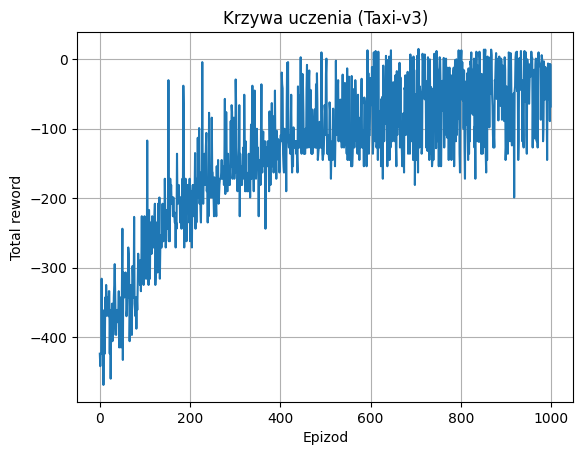

In [4]:
env = gym.make("Taxi-v3")

# Parametry Q-learningu
num_states = env.observation_space.n
num_actions = env.action_space.n
q_table = np.zeros((num_states, num_actions))

alpha = 0.1        # Współczynnik uczenia
gamma = 0.9        # Współczynnik dyskontowy
epsilon = 1.0      # Początkowy współczynnik eksploracji
epsilon_min = 0.1
epsilon_decay = 0.995
num_episodes = 1000
max_steps = 100

# Do wykresu
rewards_all_episodes = []

for episode in range(num_episodes):
    state, _ = env.reset()
    done = False
    total_rewards = 0

    for _ in range(max_steps):
        if np.random.rand() < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(q_table[state, :])

        new_state, reward, done, truncated, info = env.step(action)

        q_table[state, action] = (1 - alpha) * q_table[state, action] + \
            alpha * (reward + gamma * np.max(q_table[new_state, :]))

        state = new_state
        total_rewards += reward

        if done:
            break

    # Zmniejszanie epsilon
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    rewards_all_episodes.append(total_rewards)

print("Q-tabela (fragment):")
print(q_table[:5])

# Krzywa uczenia
plt.plot(rewards_all_episodes)
plt.xlabel("Epizod")
plt.ylabel("Total reword")
plt.title("Krzywa uczenia (Taxi-v3)")
plt.grid()
plt.show()